In [ ]:
# !pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 87.9 MB/s 


In [ ]:
model_path = '/content/drive/MyDrive/JPMC3-2-pt2y/basemodels_DA_nlcdonly/fcn_221114_final'
model2_path = None
# model2_path = '/content/drive/MyDrive/JPMC3-2-pt2y/basemodels_DA_dwonly_softlabel/fcn_221114_final'


submission_zip_name = model_path.split('/')[-2]
if model2_path != None:
    submission_zip_name = submission_zip_name + '+' + model2_path.split('/')[-2]
submission_zip_name

'basemodels_DA_nlcdonly'

In [ ]:
import os
import shutil
import time
import random
import math
import re
import sys
import gc
import rasterio
import datetime
import argparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from osgeo import gdal, ogr, osr

from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Dec 16 04:44:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    51W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
SEED_NUM = 3

SPL_WH = 388
NUM_SPLITS = int(3880 / SPL_WH) # Train in 1 epoch using image in (NUM_SPLITS ** 2, 4, 3880 / NUM_SPLITS, 3880 / NUM_SPLITS)

ROOT_PATH = '/content/'
MAIN_DIRECTORY =  ROOT_PATH + 'drive/MyDrive/JPMC3-2-pt2y' # Set the directory to save and load files

In [ ]:
# Not need to change these path unless you  want to

CODALAB_NAIP_DIRECTORY = MAIN_DIRECTORY + '/data/codalab_test_image/'
CODALAB_PRED_DIRECTORY = ROOT_PATH + 'codalab_test_prediction/'
CODALAB_SUBMISSION_DIRECTORY = ROOT_PATH + 'codalab_test_submission/'
CODALAB_SUBMISSION_ZIP_DIRECTORY = MAIN_DIRECTORY + '/codalab_submission/'

In [ ]:
NLCD_CLASSES = [0, 11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95] # 16 classes + 1 nodata class ("0").
NUM_DFC2021_CLASS = 5 # Output classes (0: Water, 1: Tree Canopy, 2: Low Vegetation , 3: Impervious, 4: None)
NLCD_IDX_TO_REDUCED_LC_MAP = np.array([
    4,#  0 No data 0
    0,#  1 Open Water
    4,#  2 Ice/Snow
    2,#  3 Developed Open Space
    3,#  4 Developed Low Intensity
    3,#  5 Developed Medium Intensity
    3,#  6 Developed High Intensity
    3,#  7 Barren Land
    1,#  8 Deciduous Forest
    1,#  9 Evergreen Forest
    1,# 10 Mixed Forest
    1,# 11 Shrub/Scrub
    2,# 12 Grassland/Herbaceous
    2,# 13 Pasture/Hay
    2,# 14 Cultivated Crops
    1,# 15 Woody Wetlands
    1,# 16 Emergent Herbaceious Wetlands
])

# set rescaling weights given to each class in loss function based on the distribution of target classes,
# (W, TC, LV, I) = (0.09, 0.453, 0.376, 0.081), and considering the percentage of None as 1/5 = 0.2
LOSS_WEIGHT = 1 / np.array([0.09, 0.453, 0.376, 0.081, 0.2]) / 5

In [ ]:
def padding(image_np, rgb_or_gray = "rgb", image_or_label = "image", return_pad_width = False):
    if (image_or_label == "image") & (rgb_or_gray == "rgb"):
        width, height = image_np.shape[1], image_np.shape[2]
    else:
        width, height = image_np.shape[0], image_np.shape[1]

    pw_x_bef = int((3880 - width) / 2)
    pw_x_aft = 3880 - width - pw_x_bef
    pw_y_bef = int((3880 - height) / 2)
    pw_y_aft = 3880 - height - pw_y_bef
    
    if rgb_or_gray == "rgb":
        if image_or_label == "image":
            pad_width = ((0, 0), (pw_x_bef, pw_x_aft), (pw_y_bef, pw_y_aft))
        elif image_or_label == "label":
            pad_width = ((pw_x_bef, pw_x_aft), (pw_y_bef, pw_y_aft), (0, 0))
        else:
            print ('Specify image_or_label by "image" or "label"')
            sys.exit(1)

        image_np = np.pad(image_np, pad_width,
                          constant_values = ((0, 0), (0, 0), (0, 0)))
    elif rgb_or_gray == "gray": # if rgb_or_gray == "gray", image_or_label = "label"
        image_np = np.pad(image_np, ((pw_x_bef, pw_x_aft), (pw_y_bef, pw_y_aft)),
                          constant_values = ((4, 4), (4, 4)))
    else:
        print ('Specify rgb_or_gray by "rgb" or "gray"')
        sys.exit(1)
    
    if return_pad_width:
        return(image_np, pw_x_bef, pw_x_aft, pw_y_bef, pw_y_aft)
    else:
        return(image_np)

def make_test_data(image_path, image_loader, return_pad_width = False):
    test_image_np_s = []
    pad_width = {'pw_x_bef': [], 'pw_x_aft': [], 'pw_y_bef': [], 'pw_y_aft': []}
    for file in image_loader:
        ds = gdal.Open(os.path.join(image_path, file), gdal.GA_ReadOnly)
        test_image_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
        
        if return_pad_width:
            test_image_np, pw_x_bef, pw_x_aft, pw_y_bef, pw_y_aft = \
                    padding(test_image_np, rgb_or_gray = "rgb", image_or_label = "image", return_pad_width = return_pad_width)
            pad_width['pw_x_bef'].append(pw_x_bef)
            pad_width['pw_x_aft'].append(pw_x_aft)
            pad_width['pw_y_bef'].append(pw_y_bef)
            pad_width['pw_y_aft'].append(pw_y_aft)
        else:
            test_image_np = padding(test_image_np, rgb_or_gray = "rgb", image_or_label = "image", return_pad_width = return_pad_width)
        
        for i in range(NUM_SPLITS):
            for ii in range(NUM_SPLITS):
                test_image_np_s.append(test_image_np[:, i * SPL_WH:(i + 1) * SPL_WH, ii * SPL_WH:(ii + 1) * SPL_WH])
            if 3880 % SPL_WH > 0:
                test_image_np_s.append(test_image_np[:, i * SPL_WH:(i + 1) * SPL_WH, ii * SPL_WH + 3880 % SPL_WH:(ii + 1) * SPL_WH + 3880 % SPL_WH])
        if 3880 % SPL_WH > 0:
            for ii in range(NUM_SPLITS):
                test_image_np_s.append(test_image_np[:, i * SPL_WH + 3880 % SPL_WH:(i + 1) * SPL_WH + 3880 % SPL_WH, ii * SPL_WH:(ii + 1) * SPL_WH])
            test_image_np_s.append(test_image_np[:, i * SPL_WH + 3880 % SPL_WH:(i + 1) * SPL_WH + 3880 % SPL_WH, ii * SPL_WH + 3880 % SPL_WH:(ii + 1) * SPL_WH + 3880 % SPL_WH])


    test_image_np_s = np.array(test_image_np_s) / 255
    if 3880 % SPL_WH == 0:
        assert test_image_np_s.shape == (len(image_loader) * NUM_SPLITS ** 2, 4, SPL_WH, SPL_WH)
    else:
        assert test_image_np_s.shape == (len(image_loader) * (NUM_SPLITS + 1) ** 2, 4, SPL_WH, SPL_WH)

    test_data = torch.from_numpy(test_image_np_s).float().to(device)
    if return_pad_width:
        return(test_data, test_image_np_s, pad_width)
    else:
        return(test_data, test_image_np_s)

def make_test_targets(label_path):
    test_label_np_s = []
    test_label_loader = sorted([file for file in os.listdir(label_path) if file.endswith('.npy') & (file.find("gray") > -1)])
    for file in test_label_loader:
        test_label_np = np.load(os.path.join(label_path, file), gdal.GA_ReadOnly)
        test_label_np = padding(test_label_np, rgb_or_gray = "gray", image_or_label = "label")
        for i in range(NUM_SPLITS):
            for ii in range(NUM_SPLITS):
                test_label_np_s.append(test_label_np[i * SPL_WH:(i + 1) * SPL_WH, ii * SPL_WH:(ii + 1) * SPL_WH])
            if 3880 % SPL_WH > 0:
                test_label_np_s.append(test_label_np[i * SPL_WH:(i + 1) * SPL_WH, ii * SPL_WH + 3880 % SPL_WH:(ii + 1) * SPL_WH + 3880 % SPL_WH])
        if 3880 % SPL_WH > 0:
            for ii in range(NUM_SPLITS):
                test_label_np_s.append(test_label_np[i * SPL_WH + 3880 % SPL_WH:(i + 1) * SPL_WH + 3880 % SPL_WH, ii * SPL_WH:(ii + 1) * SPL_WH])
            test_label_np_s.append(test_label_np[i * SPL_WH + 3880 % SPL_WH:(i + 1) * SPL_WH + 3880 % SPL_WH, ii * SPL_WH + 3880 % SPL_WH:(ii + 1) * SPL_WH + 3880 % SPL_WH])

    test_label_np_s = np.array(test_label_np_s)
    if 3880 % SPL_WH == 0:
        assert test_label_np_s.shape == (len(test_label_loader) * NUM_SPLITS ** 2, SPL_WH, SPL_WH)
    else:
        assert test_label_np_s.shape == (len(test_label_loader) * (NUM_SPLITS + 1) ** 2, SPL_WH, SPL_WH)

    test_targets = torch.from_numpy(test_label_np_s).type(torch.LongTensor).to(device)
    return(test_targets, test_label_np_s)

def reshape_data(data):
    num_data = int(data.shape[0] / NUM_SPLITS ** 2)
    if 3880 % SPL_WH > 0:
        if data.ndim == 4:
            reshaped_data = np.empty((0, 4, 3880, 3880))
            for n in range(num_data):
                reshaped_data_r = np.empty((1, 4, 0, 3880))
                for i in range(NUM_SPLITS):
                    reshaped_data_c = np.empty((1, 4, SPL_WH, 0))
                    for ii in range(NUM_SPLITS):
                        reshaped_data_c = np.append(reshaped_data_c, data[[n * (NUM_SPLITS + 1) ** 2 + i * (NUM_SPLITS + 1) + ii], :, :, :], 3)
                    reshaped_data_c = np.append(reshaped_data_c, data[[n * (NUM_SPLITS + 1) ** 2 + i * (NUM_SPLITS + 1) + ii + 1], :, :, -3880 % SPL_WH:], 3)
                    reshaped_data_r = np.append(reshaped_data_r, reshaped_data_c, 2)
                reshaped_data_c = np.empty((1, 4, 3880 % SPL_WH, 0))
                for ii in range(NUM_SPLITS):
                    reshaped_data_c = np.append(reshaped_data_c, data[[n * (NUM_SPLITS + 1) ** 2 + (i + 1) * (NUM_SPLITS + 1) + ii], :, -3880 % SPL_WH:, :], 3)
                reshaped_data_c = np.append(reshaped_data_c, data[[n * (NUM_SPLITS + 1) ** 2 + (i + 1) * (NUM_SPLITS + 1) + ii + 1], :, -3880 % SPL_WH:, -3880 % SPL_WH:], 3)
                reshaped_data_r = np.append(reshaped_data_r, reshaped_data_c, 2)
                reshaped_data = np.append(reshaped_data, reshaped_data_r, 0)
        else:
            reshaped_data = np.empty((0, 3880, 3880))
            for n in range(num_data):
                reshaped_data_r = np.empty((1, 0, 3880))
                for i in range(NUM_SPLITS):
                    reshaped_data_c = np.empty((1, SPL_WH, 0))
                    for ii in range(NUM_SPLITS):
                        reshaped_data_c = np.append(reshaped_data_c, data[[n * (NUM_SPLITS + 1) ** 2 + i * (NUM_SPLITS + 1) + ii], :, :], 2)
                    reshaped_data_c = np.append(reshaped_data_c, data[[n * (NUM_SPLITS + 1) ** 2 + i * (NUM_SPLITS + 1) + ii + 1], :, -3880 % SPL_WH:], 2)
                    reshaped_data_r = np.append(reshaped_data_r, reshaped_data_c, 1)
                reshaped_data_c = np.empty((1, 3880 % SPL_WH, 0))
                for ii in range(NUM_SPLITS):
                    reshaped_data_c = np.append(reshaped_data_c, data[[n * (NUM_SPLITS + 1) ** 2 + (i + 1) * (NUM_SPLITS + 1) + ii], -3880 % SPL_WH:, :], 2)
                reshaped_data_c = np.append(reshaped_data_c, data[[n * (NUM_SPLITS + 1) ** 2 + (i + 1) * (NUM_SPLITS + 1) + ii + 1], -3880 % SPL_WH:, -3880 % SPL_WH:], 2)
                reshaped_data_r = np.append(reshaped_data_r, reshaped_data_c, 1)
                reshaped_data = np.append(reshaped_data, reshaped_data_r, 0)
    else:
        if data.ndim == 4:
            reshaped_data = np.empty((0, 4, 3880, 3880))
            for n in range(num_data):
                reshaped_data_r = np.empty((1, 4, 0, 3880))
                for i in range(NUM_SPLITS):
                    reshaped_data_c = np.empty((1, 4, SPL_WH, 0))
                    for ii in range(NUM_SPLITS):
                        reshaped_data_c = np.append(reshaped_data_c, data[[n * NUM_SPLITS ** 2 + i * NUM_SPLITS + ii], :, :, :], 3)
                    reshaped_data_r = np.append(reshaped_data_r, reshaped_data_c, 2)
                reshaped_data = np.append(reshaped_data, reshaped_data_r, 0)
        else:
            reshaped_data = np.empty((0, 3880, 3880))
            for n in range(num_data):
                reshaped_data_r = np.empty((1, 0, 3880))
                for i in range(NUM_SPLITS):
                    reshaped_data_c = np.empty((1, SPL_WH, 0))
                    for ii in range(NUM_SPLITS):
                        reshaped_data_c = np.append(reshaped_data_c, data[[n * NUM_SPLITS ** 2 + i * NUM_SPLITS + ii], :, :], 2)
                    reshaped_data_r = np.append(reshaped_data_r, reshaped_data_c, 1)
                reshaped_data = np.append(reshaped_data, reshaped_data_r, 0)

    return(reshaped_data)

# Make a zip file for submission to [Codalab](https://codalab.lisn.upsaclay.fr/competitions/7908)

Codalab can then compute the test IoU(s) in exactly the same way as the DFC2021 contest.


In [ ]:
# Use the git implementation of the 3rd place team of the DFC 2021 contest (as base-line model git does not include test_tiles.txt used below).
!git clone https://github.com/baoqianyue/DFC2021-Track-MSD.git

Cloning into 'DFC2021-Track-MSD'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 65 (delta 21), reused 58 (delta 17), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [ ]:
%cd /content/

/content


In [ ]:
class FCN_l5(nn.Module):
    # FCN model with 5 layers
    # Input: 4D tensor (batch_size, num_input_channels, input_size, input_size)

    def __init__(self, num_input_channels, num_output_classes, kernel_size = 3, padding = 1, num_filters = 64):
        super(FCN_l5, self).__init__()

        self.conv1 = nn.Conv2d(num_input_channels, num_filters,
                               kernel_size = kernel_size, stride = 1, padding = padding)
        self.conv2 = nn.Conv2d(num_filters, num_filters,
                               kernel_size = kernel_size, stride = 1, padding = padding)
        self.last = nn.Conv2d(num_filters, num_output_classes,
                               kernel_size = 1          , stride = 1, padding = 0)
        
    def forward(self, inputs):
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = self.last(x)

        return x  # Output: 4D tensor (batch_size, num_output_classes, input_size, input_size)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') ### For GPU
model = FCN_l5(num_input_channels = 4, num_output_classes = NUM_DFC2021_CLASS).to(device)
model.load_state_dict(torch.load(model_path))
model = model.to(device)

if model2_path == None:
    model2 = None
else:
    model2 = FCN_l5(num_input_channels = 4, num_output_classes = NUM_DFC2021_CLASS).to(device)
    model2.load_state_dict(torch.load(model2_path))
    model2 = model2.to(device)

In [ ]:
# df = pd.read_csv(ROOT_PATH + 'DFC2021-Track-MSD/data/test_tiles.txt', header = None)
# df = df.rename(columns = {0:'id'})

# def id_to_url_2013(id):
#     url = 'https://dfc2021.blob.core.windows.net/competition-data/naip-2013/' + str(id) + '_naip-2013.tif'
#     return url

# def id_to_url_2017(id):
#     url = 'https://dfc2021.blob.core.windows.net/competition-data/naip-2017/' + str(id) + '_naip-2017.tif'
#     return url

# df['url_2013'] = df['id'].apply(id_to_url_2013)
# df['url_2017'] = df['id'].apply(id_to_url_2017)

In [ ]:
# # Need to run once at first running of this code
# start_time = time.time()
# shutil.rmtree(CODALAB_NAIP_DIRECTORY, ignore_errors = True)
# for url in df['url_2013']:
#     download_file(save_path = CODALAB_NAIP_DIRECTORY, save_file_name = url[65:], url = url)
# for url in df['url_2017']:
#     download_file(save_path = CODALAB_NAIP_DIRECTORY, save_file_name = url[65:], url = url)
# (time.time() - start_time) / 60

In [ ]:
def make_save_codalab_preds(model, test_data, pad_width, bsize, image_loader, model2):
    test_preds_s = np.empty((0, SPL_WH, SPL_WH))
    for i in range(int(test_data.shape[0] / bsize)):
        test_outputs = model(test_data[i * bsize:(i + 1) * bsize])
        if model2 != None:
            test_outputs2 = model2(test_data[i * bsize:(i + 1) * bsize])
            test_outputs = (test_outputs + test_outputs2) / 2
        test_preds = torch.max(test_outputs, dim = 1).indices
        test_preds_s = np.append(test_preds_s, test_preds.to('cpu').detach().numpy().copy(), 0)

    if test_data.shape[0] % bsize > 0:
        test_outputs = model(test_data[(i + 1) * bsize:])
        if model2 != None:
            test_outputs2 = model2(test_data[i * bsize:(i + 1) * bsize])
            test_outputs = (test_outputs + test_outputs2) / 2 
        test_preds = torch.max(test_outputs, dim = 1).indices
        test_preds_s = np.append(test_preds_s, test_preds.to('cpu').detach().numpy().copy(), 0)

    codalab_test_preds_s = reshape_data(test_preds_s).reshape([-1, 3880, 3880])
    num_data = len(image_loader)
    assert codalab_test_preds_s.shape == (num_data, 3880, 3880)

    ######################################################
    ### Tentative implementation: 

    # Class "None" -> modified to "Tree Canopy" (because TC is most prevalent)
    codalab_test_preds_s[codalab_test_preds_s == 4] = 1

    ######################################################

    for n in range(num_data):
        codalab_test_preds = codalab_test_preds_s[n]
        pw_x_bef = pad_width['pw_x_bef'][n]
        pw_x_aft = pad_width['pw_x_aft'][n]
        pw_y_bef = pad_width['pw_y_bef'][n]
        pw_y_aft = pad_width['pw_y_aft'][n]
        file = image_loader[n]

        if pw_x_aft > 0:
            codalab_test_preds = codalab_test_preds[pw_x_bef:-pw_x_aft, :]
        else:
            codalab_test_preds = codalab_test_preds[pw_x_bef:, :]
        if pw_y_aft > 0:
            codalab_test_preds = codalab_test_preds[:, pw_y_bef:-pw_y_aft]
        else:
            codalab_test_preds = codalab_test_preds[:, pw_y_bef:]

        with rasterio.open(os.path.join(CODALAB_NAIP_DIRECTORY, file)) as f:
            input_profile = f.profile.copy()

        output_profile = input_profile.copy()
        output_profile["driver"] = "GTiff"
        output_profile["dtype"] = "uint8"
        output_profile["count"] = 1
        output_profile["nodata"] = 0

        output_fn = file.replace("naip", "predictions")
        output_fn = os.path.join(CODALAB_PRED_DIRECTORY, output_fn)

        with rasterio.open(output_fn, "w", **output_profile) as f:
            f.write(codalab_test_preds, 1)

In [ ]:
codalab_test_image_loader = sorted([file for file in os.listdir(CODALAB_NAIP_DIRECTORY) if file.endswith('.tif')])
shutil.rmtree(CODALAB_PRED_DIRECTORY, ignore_errors = True)
os.makedirs(CODALAB_PRED_DIRECTORY, exist_ok = True)

start_time = time.time()
for ite in tqdm(range(len(codalab_test_image_loader))):
    test_data, _, pad_width = make_test_data(image_path = CODALAB_NAIP_DIRECTORY,
                                             image_loader = [codalab_test_image_loader[ite]], return_pad_width = True)
    make_save_codalab_preds(model = model, test_data = test_data, pad_width = pad_width,
                            bsize = 4, image_loader = [codalab_test_image_loader[ite]],
                            model2 = model2)
    
    if ite == 0:
        print("\nmemory_usage_after_codalab_preds")
        print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
        print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
        print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))
time_lapsed = time.time() - start_time
print(f'\n{int(time_lapsed // 60)} min {int(time_lapsed % 60)} sec lapsed')

  1%|          | 1/114 [00:09<17:35,  9.34s/it]


memory_usage_after_codalab_preds
torch.cuda.memory_allocated: 0.250149GB
torch.cuda.memory_reserved: 1.076172GB
torch.cuda.max_memory_reserved: 1.076172GB


100%|██████████| 114/114 [07:10<00:00,  3.77s/it]


7 min 10 sec lapsed


In [ ]:
##########################################################################################
### Adapt from independent_pairs_to_predictions.py in the git of baseline or 3rd-place team
##########################################################################################

shutil.rmtree(CODALAB_SUBMISSION_DIRECTORY, ignore_errors = True)
%cd /content/DFC2021-Track-MSD


parser = argparse.ArgumentParser(description = 'Helper script for combining DFC2021 prediction into submission format')
parser.add_argument('--input_dir', type = str, required = True,
                    help = 'The path to a directory containing the output of the `inference.py` script.')
parser.add_argument('--output_dir', type = str, required = True,
                    help = 'The path to output the consolidated predictions, should be different than `--input_dir`.')
parser.add_argument('--overwrite', action = "store_true", help = 'Flag for overwriting `--output_dir` if that directory already exists.')
parser.add_argument('--soft_assignment', action = "store_true",
                    help = 'Flag for combining predictions using soft assignment. You can only use this if you ran the `inference.py` script with the `--save_soft` flag.')
args = parser.parse_args(args=['--input_dir', CODALAB_PRED_DIRECTORY, '--output_dir', CODALAB_SUBMISSION_DIRECTORY])


def main():
    print("Starting to combine predictions at %s" % (str(datetime.datetime.now())))

    #-------------------
    # Setup
    #-------------------
    assert os.path.exists(args.input_dir) and len(os.listdir(args.input_dir)) > 0

    if os.path.isfile(args.output_dir):
        print("A file was passed as `--output_dir`, please pass a directory!")
        return

    if os.path.exists(args.output_dir) and len(os.listdir(args.output_dir)) > 0:
        if args.overwrite:
            print("WARNING! The output directory, %s, already exists, we might overwrite data in it!" % (args.output_dir))
        else:
            print("The output directory, %s, already exists and isn't empty. We don't want to overwrite and existing results, exiting..." % (args.output_dir))
            return
    else:
        print("The output directory doesn't exist or is empty.")
        os.makedirs(args.output_dir, exist_ok=True)


    #-------------------
    # Run for each pair of predictions that we find in `--input_dir`
    #-------------------
    idxs_2013 = [
        fn.split("_")[0]
        for fn in os.listdir(args.input_dir)
        if fn.endswith("predictions-2013.tif")
    ]

    idxs_2017 = [
        fn.split("_")[0]
        for fn in os.listdir(args.input_dir)
        if fn.endswith("predictions-2017.tif")
    ]

    assert len(idxs_2013) > 0, "No matching files found in '%s'" % (args.input_dir)
    assert set(idxs_2013) == set(idxs_2017), "Missing some predictions"

    for i, idx in enumerate(idxs_2013):
        tic = time.time()

        print("(%d/%d) Processing tile %s" % (i, len(idxs_2013), idx), end = " ... ")

        if args.soft_assignment:
            fn_2013 = os.path.join(args.input_dir, "%s_predictions-soft-2013.tif" % (idx))
            fn_2017 = os.path.join(args.input_dir, "%s_predictions-soft-2017.tif" % (idx))
        else:
            fn_2013 = os.path.join(args.input_dir, "%s_predictions-2013.tif" % (idx))
            fn_2017 = os.path.join(args.input_dir, "%s_predictions-2017.tif" % (idx))
        output_fn = os.path.join(args.output_dir, "%s_predictions.tif" % (idx))

        assert os.path.exists(fn_2013) and os.path.exists(fn_2017)

        ## Load the independent predictions for both years
        with rasterio.open(fn_2013) as f:
            if args.soft_assignment:
                t1 = np.rollaxis(f.read(), 0, 3)
            else:
                t1 = f.read(1)
            input_profile = f.profile.copy() # save the metadata for writing output
            
        with rasterio.open(fn_2017) as f:
            if args.soft_assignment:
                t2 = np.rollaxis(f.read(), 0, 3)
            else:
                t2 = f.read(1)

        t1_reduced = t1  # changed from the original git implementation
        t2_reduced = t2  # changed from the original git implementation

        ## Convert the two layers of predictions into the format expected by codalab
        predictions = (t1_reduced * 4) + t2_reduced
        predictions[predictions == 5] = 0
        predictions[predictions == 10] = 0
        predictions[predictions == 15] = 0
        predictions = predictions.astype(np.uint8)

        ## Write output as GeoTIFF
        input_profile["count"] = 1
        with rasterio.open(output_fn, "w", **input_profile) as f:
            f.write(predictions, 1)

        print("finished in %0.4f seconds" % (time.time() - tic))

if __name__ == "__main__":
    main()

/content/DFC2021-Track-MSD
Starting to combine predictions at 2022-12-16 04:53:58.025949
The output directory doesn't exist or is empty.
(0/57) Processing tile 2496 ... finished in 0.2654 seconds
(1/57) Processing tile 2434 ... finished in 0.1846 seconds
(2/57) Processing tile 3518 ... finished in 0.2465 seconds
(3/57) Processing tile 2773 ... finished in 0.3152 seconds
(4/57) Processing tile 2609 ... finished in 0.2186 seconds
(5/57) Processing tile 3683 ... finished in 0.2749 seconds
(6/57) Processing tile 3872 ... finished in 0.2464 seconds
(7/57) Processing tile 3925 ... finished in 0.2328 seconds
(8/57) Processing tile 2932 ... finished in 0.2420 seconds
(9/57) Processing tile 5113 ... finished in 0.2106 seconds
(10/57) Processing tile 3628 ... finished in 0.2561 seconds
(11/57) Processing tile 3770 ... finished in 0.2007 seconds
(12/57) Processing tile 2931 ... finished in 0.2252 seconds
(13/57) Processing tile 2610 ... finished in 0.2222 seconds
(14/57) Processing tile 3322 ... 

You can sign up to Codalab and submit the zip file after downloading it.


In [ ]:
os.makedirs(CODALAB_SUBMISSION_ZIP_DIRECTORY, exist_ok = True)
os.chdir(CODALAB_SUBMISSION_ZIP_DIRECTORY)
shutil.make_archive(submission_zip_name, format = 'zip', root_dir = CODALAB_SUBMISSION_DIRECTORY)

'/content/drive/MyDrive/JPMC3-2-pt2y/codalab_submission/basemodels_DA_nlcdonly.zip'

## Check the output

In [ ]:
codalab_pred_loader = sorted([file for file in os.listdir(CODALAB_SUBMISSION_DIRECTORY) if file.endswith('.tif')])

for i, file in enumerate(tqdm(codalab_pred_loader)):
    ds = gdal.Open(os.path.join(CODALAB_SUBMISSION_DIRECTORY, file), gdal.GA_ReadOnly)
    codalab_pred_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
    if max(codalab_pred_np[0].flatten()) > 14:
        print(f'\n\n{file} is wrong!')
        print(f'\nsize: ({ds.RasterXSize}, {ds.RasterYSize})\n')
        print(pd.Series(codalab_pred_np[0].flatten()).value_counts())
        break
    if i == len(codalab_pred_loader) - 1:
        print('\n\nThe format looks OK')

100%|██████████| 57/57 [01:01<00:00,  1.09s/it]



The format looks OK


[[[1 1 1 ... 2 2 2]
  [1 1 1 ... 2 2 2]
  [1 1 1 ... 2 2 2]
  ...
  [1 1 1 ... 3 2 2]
  [1 1 1 ... 3 2 2]
  [1 1 1 ... 3 2 2]]]
(1, 3880, 3880)
3880 3880
1    7142563
3    6036204
2    1097385
0     778248
dtype: int64


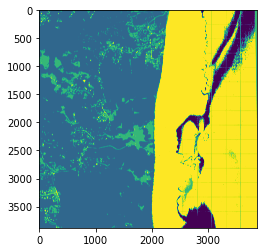

In [ ]:
ds = gdal.Open(CODALAB_PRED_DIRECTORY + '3598_predictions-2017.tif', gdal.GA_ReadOnly)
exmp = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
print(exmp)
print(exmp.shape)
print(ds.RasterXSize, ds.RasterYSize)
print(pd.Series(exmp[0].flatten()).value_counts())
plt.imshow(exmp[0])

[[[2 1 1 ... 2 2 2]
  [1 1 1 ... 2 2 2]
  [1 1 1 ... 2 2 2]
  ...
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]]]
(1, 3880, 3880)
3880 3880
0    6777452
1    6370419
2    1680877
3     225652
dtype: int64


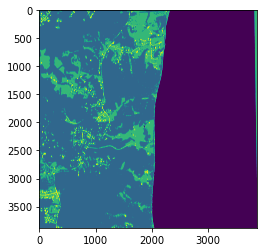

In [ ]:
ds = gdal.Open(CODALAB_PRED_DIRECTORY + '3598_predictions-2013.tif', gdal.GA_ReadOnly)
exmp = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
print(exmp)
print(exmp.shape)
print(ds.RasterXSize, ds.RasterYSize)
print(pd.Series(exmp[0].flatten()).value_counts())
plt.imshow(exmp[0])

[[[9 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 3 2 2]
  [0 0 0 ... 3 2 2]
  [0 0 0 ... 3 2 2]]]
(1, 3880, 3880)
3880 3880
0     7995017
3     5907714
9      790240
2       94377
14      89102
6       70789
13      55162
11      44108
8        3412
7        3284
1         860
12        290
4          45
dtype: int64


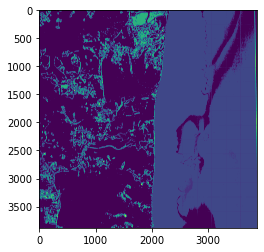

In [ ]:
ds = gdal.Open(CODALAB_SUBMISSION_DIRECTORY + '3598_predictions.tif', gdal.GA_ReadOnly)
exmp = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
print(exmp)
print(exmp.shape)
print(ds.RasterXSize, ds.RasterYSize)
print(pd.Series(exmp[0].flatten()).value_counts())
plt.imshow(exmp[0])